# 0. Setup

In [1]:
# TO REMOVE
! pip install transformers newspaper3k datasets urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 11.5 MB/s 
     |████████████████████████████████| 211 kB 66.6 MB/s 
     |████████████████████████████████| 452 kB 59.6 MB/s 
     |████████████████████████████████| 127 kB 53.9 MB/s 
     |████████████████████████████████| 7.6 MB 41.3 MB/s 
     |████████████████████████████████| 182 kB 55.4 MB/s 
     |████████████████████████████████| 93 kB 3.1 MB/s 
     |████████████████████████████████| 7.4 MB 50.9 MB/s 
     |████████████████████████████████| 81 kB 3.8 MB/s 
     |████████████████████████████████| 213 kB 75.9 MB/s 
     |████████████████████████████████| 132 kB 79.3 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=3016d3dedf9544bfe4b113cbd27f869b114d724d52fbdbac555b9ddad6dd93e3
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c0

In [2]:
import urllib3
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Union, Any
from tqdm import tqdm
import newspaper
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import datasets
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, load_dataset
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel, TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import spacy

In [4]:
import spacy

In [5]:
# TO REMOVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 0.1 Defining variables

In [6]:
URL = 'url'
TEXT = 'text'
LEMMATIZED = 'cleaned_lemmatized_text'
TARGET = 'label'

MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'

html_folder = HTML_FOLDER # is it being used or I can delete it?

nlp = spacy.load('en_core_web_sm')

DISTILBERT_MAX_INPUT = 510 # 512 - the [CLS] and [SEP] tokens

labels_encoded = {'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}
labels_decoded = {y: x for x, y in labels_encoded.items()}

maximum_classes = len(labels_encoded)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [7]:
os.chdir(MAIN_FOLDER)

# 0.2 Functions

## Saving/loading variables

In [8]:
def save_variables(variables: Dict[str, Any]) -> None:
  """
  Saves variables to disk using pickle.
  
  @variables: dictionary where the keys are the names to use when saving the variables, and the values are the variables to be saved.
  
  Returns:
  None
  """

  for variable_name, variable in variables.items():
    with open(f'./saved_variables/{variable_name}.pickle', 'wb') as f:
      pickle.dump(variable, f)


def read_variable(variable_name):
  """
  Loads a variable previously saved in disk using pickle.

  @variable_name: path of the variable saved

  Returns:
  - variable: the loaded variable
  """

  with open(f'./saved_variables/{variable_name}.pickle', 'rb') as f:
    variable = pickle.load(f)
  return variable

## Preprocessing

In [9]:
def read_csv(csv_path: str, usecols: List[str] = None, namecols: List[str] = None, remove_nan: str = None, ignore_dash: bool = False) -> pd.DataFrame:
  """
  Create a DataFrame from a CSV file.

  @csv_path: the path to the CSV file.
  @usecols: a list of column names to use from the CSV file. If not provided, all columns will be used.
  @namecols: a list of new names for the columns from the CSV file. If not provided, the original column names will be used.
  @remove_nan: the name of the column from where rows with missing values will be removed. It must be from namecols (or from usecols, if namecols was not provided). If not provided, all rows will be kept.
  @ignore_dash: a flag indicating whether to ignore rows with a dash (`-`) in the target column. If not provided, rows with a dash in the target column will be included in the data.

  Returns: 
  - df: a pandas DataFrame object.
  """

  df = pd.read_csv(csv_path, usecols=usecols)

  if namecols:
    assert len(usecols) == len(namecols)
    rename_columns = {usecols[i]: namecols[i] for i in range(len(usecols))}
    df.rename(columns=rename_columns, inplace=True)
  
  if remove_nan:
    df = df[~df[remove_nan].isna()]

  if ignore_dash:
    df = df[df['label'] != '-']
  
  df.loc[df[TARGET] == 'MISC/Blog?', TARGET] = 'MISC' # all sections of blogs labeled as 'MISC/Blog?' become part of 'MISC'.

  df.reset_index(drop=True, inplace=True)

  return df


def read_htmls(df: pd.DataFrame, column: str) -> List[str]:
  """
  Read HTML files from a pandas DataFrame.

  @df: a DataFrame with a column containing the names of the HTML files.
  @column: the name of the column in the DataFrame where the filenames are stored.

  Returns: 
  - htmls: a list of strings, one for each HTML file.
  """

  filenames = df[column].values
  htmls = list()

  for i, filename in enumerate(tqdm(filenames)):
    try:
      with open(f'{HTML_FOLDER}{filename}') as f:
        html = f.read()
        htmls.append(html)
    except FileNotFoundError:
      print(f'File {i} not found: "{filename}"')
  
  return htmls


def read_articles(htmls: List[str]) -> List[newspaper.article.Article]:
  """
  Read articles from a list of HTML strings.
  
  @htmls: a list of HTML strings representing articles.
  
  Returns: 
  - toi_articles: a list of newspaper.article.Article objects, one for each HTML string.
  """
  
  toi_articles = list()

  for html in tqdm(htmls):
    toi_article = Article(url = ' ', language = 'en')
    toi_article.set_html(html)
    toi_article.parse()
    toi_article.nlp()
    toi_articles.append(toi_article)

  return toi_articles


def create_df_from_articles(df: pd.DataFrame, toi_articles: List[newspaper.article.Article]) -> pd.DataFrame:
  """
  Create a DataFrame with article text and labels from a list of articles.
  
  @df: a DataFrame with a TARGET column containing the labels for the articles.
  @toi_articles: a list of newspaper.article.Article objects.
  
  Returns: a DataFrame with two columns: TEXT, containing the concatenated title and text of the articles, and TARGET, containing the labels for the articles.
  """

  summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]
  y = df[TARGET].tolist()
  assert len(y) == len(summaries)

  df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

  return df_text1

In [10]:
def read_or_create_variables(variable_names: List[str]) -> List[Any]:
  """
  Read or create variables with the given names. If a variable exists, it is read and returned. 
  If a variable with a given name does not exist, it is created and an empty list is returned.
  
  @variable_names: list of strings representing the names of the variables to be read and/or created.
  
  Returns:
  - variables: list of the read and/or created variables.
  """

  variables = list()

  for variable_name in variable_names:
    try:
      variable = read_variable(variable_name)
      print(f'SUCCESS: variable {variable_name} was read, it contains {len(variable)} elements.')
    except FileNotFoundError:
      variable = list()
      print(f'Variable {variable_name} was just created and contains {len(variable)} elements.')

    variables.append(variable)

  return variables


def create_new_urls(df: pd.DataFrame, column: str) -> pd.Series:
  """
  Creates the urls to read based on the difference between all URLs and the ones already read.

  @df (pd.DataFrame): a DataFrame with a column containing the URLs.
  @column (str): the name of the column in the DataFrame where the URLs are stored.

  Returns:
  - urls_new: pandas Series object with strings of the URLs to read.
  """

  urls = df[column]
  mask = np.isin(urls, urls_old)
  urls_new = urls[~mask]
  print(f'There are {len(urls_new)} new URLs to read.')

  return urls_new


def read_texts_from_urls(urls_new: pd.Series, urls_old: List[str]) -> Tuple[List[str], List[int], List[int]]:
  """
  Reads the relevant text from each URL.

  @urls_new: pandas Series object with strings of the URLs to read.
  @urls_old: list of strings of the URLs that have already been read.
  
  Returns a tuple of three elements:
  - texts_new: list of strings of the texts read from the URLs.
  - indexes_new: list of integers representing the indexes of the URLs that were read successfully.
  - idx_label_to_remove: list of integers representing the indexes, starting from 0, that threw errors and should be deleted.
  """

  texts_new = list()
  indexes_new = list()

  idx_label_to_remove = list()
  idx_label = 0

  for i, url in enumerate(urls_new, len(urls_old)):
    try:
      toi_article = Article(url=url, language='en')
      toi_article.download()
      toi_article.parse()
      toi_article.nlp()
      text = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
      texts_new.append(text)
      indexes_new.append(i)
      print(f'{i}: url "{url}" read successfully.')
    except Exception:
      idx_label_to_remove.append(idx_label)
      print(f'{i}: ERROR: url "{url}" was not read successfully.')
    
    idx_label += 1
  
  if idx_label_to_remove:
    print(f'\nWhen reading the new URLs, {len(urls_new) - len(indexes_new)} of them threw an error and could not be read.')
  elif texts_new:
    print('All URLs were successfully read.')
  else:
    print('No new URL was read.')

  return texts_new, indexes_new, idx_label_to_remove


def create_new_labels(df: pd.DataFrame, urls_to_read: pd.Series, idx_label_to_remove: List[int]) -> List[str]:
  """
  Creates a list of labels for the given URLs and removes the labels corresponding to the URLs that threw errors.
  
  @df: pandas DataFrame containing the labels.
  @urls_to_read: pandas Series object with strings of the URLs for which the labels should be created.
  @idx_label_to_remove: list of integers representing the indexes of the URLs that threw errors and should have their labels removed.
  
  Returns:
  - labels_new: list of labels according to the new URLs, discarding the ones that threw errors.
  """
  
  labels_new = df.loc[urls_to_read.index, TARGET]
  assert (labels_new == df.loc[labels_new.index, TARGET]).all()
  labels_new.reset_index(drop=True, inplace=True)
  labels_new = labels_new.drop(idx_label_to_remove).tolist()

  return labels_new


def update_variables(old_variables: List[Any], new_variables: List[Any]) -> List[Any]:
  """
  Updates the old variables with the new variables.
  
  @old_variables: list of variables that should be updated.
  @new_variables: list of variables used to update the old variables, should be of same length and order as `old_variables`.
  
  Returns:
  - updated_variables: list of variables that are the result of updating the old variables with the new variables.
  """

  assert len(old_variables) == len(new_variables)

  updated_variables = list()
  zipped_variables = list(zip(old_variables, new_variables))

  for old_var, new_var in zipped_variables:
    updated_variable = old_var + new_var
    updated_variables.append(updated_variable)

  return updated_variables


def create_df_from_lists(labels: List[str], indexes: List[int], texts: List[str], urls: List[str]) -> pd.DataFrame:
  """
  Creates a pandas DataFrame with columns for URLs, texts, and labels.
  
  @labels: list of strings representing the labels of the articles.
  @indexes: list of integers representing the indexes of the articles.
  @texts: list of strings representing the texts of the articles.
  @urls: list of strings representing the URLs of the articles.
  
  Returns:
  - df_text2: pandas DataFrame with columns for URLs, texts, and labels.
  """

  df_text2 = pd.DataFrame({
      URL: pd.Series(urls).loc[indexes],
      TEXT: texts,
      TARGET: labels,
      }).reset_index(drop=True)

  return df_text2

In [11]:
def remove_duplicates(df: pd.DataFrame, column: str) -> pd.DataFrame:
  """
  Remove duplicate rows from a DataFrame based on a specific column.
  
  Parameters:
  - df: a DataFrame with a column containing values to be checked for duplicates.
  - column: the name of the column in the DataFrame where the values are stored.
  
  Returns:
  - df: DataFrame with duplicate rows removed. If there were no duplicates, the original DataFrame is returned.
  """

  if df[column].duplicated().any():
    original_amount = df.shape[0]
    df = df[~df[column].duplicated()]
    print(f"{original_amount - df.shape[0]} rows had duplicate values in the dataframe's column '{column}' and were deleted.")
    assert not df[column].duplicated().any()

  else:
    print(f"There are no duplicate values in the dataframe's column '{column}'.")
  
  return df


def remove_rows(df: pd.DataFrame, with_errors: bool = False, irrelevant: bool = False, below_threshold: int = None) -> pd.DataFrame:
  """
  Removes rows from a pandas DataFrame that meet certain conditions.
  
  Parameters:
  - df: pandas DataFrame from which rows should be removed.
  - with_errors: boolean flag indicating whether rows with URLs' texts that throw errors should be removed. If set to True, rows with texts that have less than 100 words and contain both the strings " 404 " and " error " will be removed.
  - irrelevant: boolean flag indicating whether rows with irrelevant labels should be removed. If set to True, rows with labels that are not included in the dictionary `labels_encoded` will be removed.
  - below_threshold: integer representing the minimum number of words that the text of a URL must contain for it to be included in the final DataFrame. Rows with texts containing fewer words than this threshold will be removed.

  Returns:
  - df: pandas DataFrame with rows that met a condition removed.
  """

  if with_errors:
    words = df[TEXT].str.split().str.len()
    condition1 = words < 100 # empirical threshold
    condition2 = df[TEXT].str.contains(' 404 ')
    condition3 = df[TEXT].str.contains(' error ')
    df = df[~(condition1 & condition2 & condition3)]

  if irrelevant:
    df = df[df[TARGET].isin(labels_encoded)]
    df.reset_index(drop=True, inplace=True)

  # If the words that the text a URL contains is below this threshold, the row is discarded
  if below_threshold:
    words = df[TEXT].str.split().str.len()
    df = df[words >= below_threshold]

  return df


def text_preprocessing(text: str, lemmatize: bool = False, clean: bool = False) -> str:
  """
  Preprocess text by applying lemmatization and cleaning operations.
  
  Parameters:
  - text: a string of the text to be preprocessed.
  - lemmatize: a flag indicating whether to apply lemmatization to the text. Default is False.
  - clean: a flag indicating whether to clean the text. Default is False.
  
  Returns:
  - text: a string of the preprocessed text.
  """

  if lemmatize:
    text = ' '.join(token.lemma_ for token in nlp(text))
  
  if clean:
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

  return text

In [12]:
def split_data(df: pd.DataFrame, column: str, test_size: float = 0.2, val_size: float = None, random_state: int = None) -> Union[Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series], Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]]:
  """
  Splits a pandas DataFrame into training, validation (if needed), and test sets.
  Data is split in a stratified fashion according to `df[TARGET]`.
  
  Parameters:
  - df: pandas DataFrame containing the data to be split.
  - column: name of the column in the DataFrame to be used as the input data (X).
  - test_size: float representing the proportion of the whole data to be used for the test set. Must be between 0.0 and 1.0.
  - val_size: float representing the proportion of the whole data to be used for the validation set. Must be between 0.0 and 1.0.
  - random_state: integer seed for the random number generator.
  
  Returns:
  - X_train: pandas DataFrame containing the input data for the training set.
  - (if `val_size` is provided) X_val: pandas DataFrame containing the input data for the validation set.
  - X_test: pandas DataFrame containing the input data for the test set.
  - y_train: pandas Series containing the target data for the training set.
  - (if `val_size` is provided) y_val: pandas Series containing the target data for the validation set.
  - y_test: pandas Series containing the target data for the test set.
  """

  X = df[[column]]
  y = df[TARGET]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size,
                                                      stratify=y, 
                                                      random_state=random_state
                                                      )
  
  if val_size:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=1/((1-test_size)/val_size),
                                                      stratify=y_train, 
                                                      random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

  return X_train, X_test, y_train, y_test


def vectorize_data(column: str, X_train: pd.DataFrame, X_test: pd.DataFrame, X_val: pd.DataFrame = None, ngram_range: Tuple[int, int] = (1, 1)) -> Union[Tuple[pd.DataFrame, pd.DataFrame], Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]]:
  """
  Vectorizes the data in a pandas DataFrame column using the TfidfVectorizer.
  
  Parameters:
  - column: name of the column in the DataFrame to be vectorized.
  - X_train: pandas DataFrame containing the input data for the training set.
  - X_test: pandas DataFrame containing the input data for the test set.
  - X_val: (optional) pandas DataFrame containing the input data for the validation set.
  - ngram_range: tuple of integers specifying the lower and upper boundaries of the range of n-values for different n-grams to be extracted.
  
  Returns:
  - X_train: pandas DataFrame containing the vectorized input data for the training set.
  - X_test: pandas DataFrame containing the vectorized input data for the test set.
  - (if `X_val` is provided) X_val: pandas DataFrame containing the vectorized input data for the validation set.
  """

  vectorizer = TfidfVectorizer(ngram_range=ngram_range)
  X_train_tr = vectorizer.fit_transform(X_train[column])
  X_test_tr = vectorizer.transform(X_test[column])

  if X_val:
    X_val_tr = vectorizer.transform(X_val[column])

    return X_train_tr, X_val_tr, X_test_tr

  return X_train_tr, X_test_tr

In [13]:
def create_dataset_dict(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, 
                       y_test: pd.Series, X_val: pd.DataFrame = None, y_val: pd.Series = None) -> DatasetDict:
  """
  Creates a DatasetDict object from pandas DataFrames and Series.
  
  Parameters:
  - X_train: pandas DataFrame containing the input data for the training set.
  - X_test: pandas DataFrame containing the input data for the test set.
  - y_train: pandas Series containing the target data for the training set.
  - y_test: pandas Series containing the target data for the test set.
  - X_val: (optional) pandas DataFrame containing the input data for the validation set.
  - y_val: (optional) pandas Series containing the target data for the validation set.
  
  Returns:
  - dataset: DatasetDict object containing the training, validation (optional) and test sets.
  """

  datasets = {
    'train': Dataset.from_dict(
        {TEXT: X_train[TEXT],
         TARGET: y_train,
         }
         ),
    'test': Dataset.from_dict(
        {TEXT: X_test[TEXT],
         TARGET: y_test,
         }
         )
    }
  
  if X_val is not None and y_val is not None:
    datasets['validation'] = Dataset.from_dict(
        {TEXT: X_val[TEXT],
         TARGET: y_val,
         }
         )

  dataset = DatasetDict(datasets)
  
  return dataset


def tokenize(batch: Dict[str, Any]) -> Dict[str, Any]:
  """
  Tokenizes the text data in a batch.
  
  Parameters:
  - batch: dictionary containing the batch data.
  
  Returns:
  - batch: dictionary with the text data tokenized.
  """

  return tokenizer(batch[TEXT], padding=True, truncation=True)


def extract_hidden_states(batch: Dict[str, Any]) -> Dict[str, Any]:
  """
  Extracts the hidden states of the input text in a batch.
  
  Parameters:
  - batch: dictionary containing the batch data.
  
  Returns:
  - hidden_state: numpy array with the hidden states for the [CLS] tokens of the input texts in the batch.
  """

  # Convert text to tokens
  inputs = tokenizer(
      batch[TEXT], 
      padding=True, 
      truncation=True, 
      return_tensors='tf',
      )
  
  # Extract last hidden states
  outputs = tf_model(inputs)

  # Return vector for [CLS] token
  return {'hidden_state': outputs.last_hidden_state[:, 0].numpy()}

## Modeling

In [49]:
def fit_model(clf, X_train, y_train):
  clf.fit(X_train, y_train)
  return clf


def predict(clf, X_test):
  y_pred = clf.predict(X_test)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def print_stratified_kfold(clfs: List[Tuple[str, Any]], X_train: pd.DataFrame, y_train: pd.Series, n_splits: int = 5, cv: int = 5) -> None:
  """
  Prints the results of a Stratified K-Fold cross-validation for a list of classifiers.
  
  Parameters:
  - clfs: a list of tuples with a string representing the name of the classifier and the classifier object.
  - X_train: the training data, as a Pandas DataFrame.
  - y_train: the training labels, as a Pandas Series.
  - n_splits: the number of splits for the Stratified K-Fold cross-validation. Default is 5.
  - cv: the number of folds for the cross-validation. Default is 5.

  Returns:
  - None
  """
  
  for clf in clfs:
    print(f'\nStratifiedKFold - classifier: {clf[0]}:\n')
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, val_index in skf.split(X_train, y_train):
        print_train_val_len_start(train_index, val_index)
        print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

    scores = cross_val_score(clf[1], 
                            X_train,
                            y_train,
                            cv=cv)
    
    print_val_scores(scores)


def create_df_mistakes(df_text: pd.DataFrame, column: str, X_test: pd.DataFrame, y_test: pd.Series, y_pred: Union[np.ndarray, pd.Series], y_probs: np.ndarray) -> pd.DataFrame:
  """
  Creates a pandas DataFrame with the rows from `X_test` that have been misclassified and their respective true and predicted labels, along with the confidences of each of those predictions.
  The DataFrame also includes the URLs from `df_text` that correspond to the rows of `X_test` that have been misclassified.

  Parameters:
  - df_text: pandas DataFrame that contains the URLs of the samples in `X_test`.
  - column: string that represents the name of the column in `df_text` and `X_test` that contains the indices that link both DataFrames.
  - X_test: pandas DataFrame that contains the features of the test set.
  - y_test: pandas Series that contains the true labels of the test set.
  - y_pred: NumPy array or pandas Series with the predicted labels of the test set.
  - y_probs: NumPy array with the probabilities of each label in `y_pred`.

  Returns:
  - df_mistakes: pandas DataFrame detailed in the function explanation
  """
  
  if type(y_test) == pd.core.series.Series:
    y_pred = pd.Series(y_pred, index=y_test.index) # setting y_pred to same type and indexes as y_test
  
  elif type(y_test) == np.ndarray:
    y_pred = pd.Series(y_pred)
    y_test = pd.Series(y_test)

  mask = y_pred != y_test
    
  df = X_test.copy()[mask]
  df['y_true'] = y_test[mask].replace(labels_decoded)
  df['y_pred'] = y_pred[mask].replace(labels_decoded) 

  assert (df['y_true'] != df['y_pred']).all()

  df_mistakes = pd.merge(df, df_text[[URL, column]], on=column)
  df_mistakes.index = df.index

  df_confidences = df_mistakes[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])

  confidence_pred = y_probs[mask, df_confidences['y_pred']]
  confidence_true = y_probs[mask, df_confidences['y_true']]

  df_mistakes['conf_true'] = confidence_true.round(2)
  df_mistakes['conf_pred'] = confidence_pred.round(2)

  df_mistakes = df_mistakes[[URL, column, 'y_true', 'conf_true', 'y_pred', 'conf_pred']]

  return df_mistakes


def plot_distribution_of_confidences(y_test: pd.Series, y_pred: np.ndarray, y_probs: np.ndarray) -> None:
  """
  Plots the distribution of confidence scores for correctly and incorrectly classified samples.

  Parameters:
  - y_test: numpy array of shape (n_samples,) containing the true labels for the test set.
  - y_pred: numpy array of shape (n_samples,) containing the predicted labels for the test set.
  - y_probs: numpy array of shape (n_samples, n_classes) containing the predicted probabilities for each class in the test set.

  Returns:
  - None
  """

  sns.set_theme()

  mask = y_test != y_pred

  wrong_conf_pred = np.max(y_probs[mask], axis=1)
  right_conf_pred = np.max(y_probs[~mask], axis=1)
  assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

  print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
  print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.\n')

  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

  ax[0, 0].hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=None, color='r', alpha=0.6)
  ax[0, 0].set_title('Incorrectly classified samples', size=16)
  ax[0, 0].set_xlabel('Confidence')
  ax[0, 0].set_ylabel('Number of samples')

  ax[0, 1].hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=None, color='g', alpha=0.6)
  ax[0, 1].set_title('Correctly classified samples', size=16)
  ax[0, 1].set_xlabel('Confidence')
  ax[0, 1].set_ylabel('Number of samples')

  ax[1, 0].hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=True, color='r', alpha=0.6, cumulative=1)
  ax[1, 0].set_xlabel('Confidence')
  ax[1, 0].set_ylabel('Cumulative distribution')

  ax[1, 1].hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=True, color='g', alpha=0.6, cumulative=1)
  ax[1, 1].set_xlabel('Confidence')
  ax[1, 1].set_ylabel('Cumulative distribution')

  plt.tight_layout()
  plt.show()

  sns.reset_orig()


def create_tf_dataset(dataset_encoded: DatasetDict, tokenizer: AutoTokenizer, batch_size: int = 16) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
  """
  Convert a `DatasetDict` object to a tuple of `tf.data.Dataset` objects.

  Parameters:
  - dataset_encoded: DatasetDict object containing datasets with the encoded text data and labels.
  - tokenizer: AutoTokenizer object that will be used to encode the text data.
  - batch_size: integer representing the number of samples per batch.
  
  Returns:
  - tuple of tf.data.Dataset objects for the train, validation, and test datasets.
  """

  tokenizer_columns = tokenizer.model_input_names

  data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

  tf_train_dataset = dataset_encoded['train'].to_tf_dataset(
      columns=tokenizer_columns, 
      label_cols=[TARGET], 
      shuffle=True,
      batch_size=batch_size,
      collate_fn=data_collator
      )

  tf_val_dataset = dataset_encoded['validation'].to_tf_dataset(
      columns=tokenizer_columns, 
      label_cols=[TARGET], 
      shuffle=False,
      batch_size=batch_size,
      collate_fn=data_collator
      )

  tf_test_dataset = dataset_encoded['test'].to_tf_dataset(
      columns=tokenizer_columns,
      label_cols=[TARGET], 
      shuffle=False,
      batch_size=batch_size,
      collate_fn=data_collator
      )
  
  return tf_train_dataset, tf_val_dataset, tf_test_dataset


def create_distilbert_config(dropout: float = 0.1, attention_dropout: float = 0.1) -> transformers.DistilBertConfig:
  """
  Creates a DistilBERT configuration with specified dropout and attention dropout values.
  
  Parameters:
  - dropout: the dropout rate for the DistilBERT model. Default is 0.1.
  - attention_dropout: the attention dropout rate for the DistilBERT model. Default is 0.1.
  
  Returns:
  - A transformers.DistilBertConfig object representing the configuration of the DistilBERT model.
  """
  num_labels = len(y_train.value_counts())
 
  # Configure DistilBERT's initialization
  config = DistilBertConfig(
      dropout=dropout, 
      attention_dropout=attention_dropout,
      output_hidden_states=True,
      num_labels=num_labels,
      )
  
  return config


def compile_model(tf_model: tf.keras.Model, learning_rate: float = 5e-6) -> tf.keras.Model:
  """
  Compile a TensorFlow model with Adam optimizer and Sparse Categorical Crossentropy loss.
  
  Parameters:
  - tf_model: a TensorFlow model to be compiled.
  - learning_rate: the learning rate for the Adam optimizer. Default is 5e-6.
  
  Returns:
  - The compiled TensorFlow model.
  """

  tf_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=tf.metrics.SparseCategoricalAccuracy()
      )  
  
  return tf_model


def train_model(tf_model: tf.keras.Model, tf_train_dataset: tf.data.Dataset, tf_val_dataset: tf.data.Dataset, epochs: int = 100, patience: int = 3) -> tf.keras.Model:
  """
  Train a TensorFlow model using a training and validation datasets, with early stopping.
  
  Parameters:
  - tf_model: a compiled TensorFlow model to be trained.
  - tf_train_dataset: a TensorFlow dataset with the training data.
  - tf_val_dataset: a TensorFlow dataset with the validation data.
  - epochs: the number of epochs to train the model. Default is 100.
  - patience: the number of epochs to wait before stopping training if the validation loss doesn't improve. Default is 3.
  
  Returns:
  - The trained TensorFlow model.

  """

  callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
    )

  tf_model.fit(
      tf_train_dataset,
      validation_data=tf_val_dataset, 
      epochs=epochs,
      callbacks=[callback]
      )
  
  return tf_model

## EDA (not needed in the .py file):

In [15]:
def check_if_exists(variable_name):
  """
  Checks if a variable exists in the global scope.

  @variable_name: name of the variable

  Returns:
  None
  """
  
  if variable_name in globals():
    print(f'Variable "{variable_name}" exists.')
  else:
    print(f'Variable "{variable_name}" does not exist.')


def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)


def print_important_features(clf, vectorizer, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{labels_decoded[clf.classes_[i]]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy



def print_train_val_len_start(train_index, val_index):
    print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
          f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')


def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')


def print_confusion_matrix(clf_name, y_test, y_pred, with_report=False):

  accuracy = get_accuracy(y_test, y_pred)

  y_test = list(map(lambda x: labels_decoded[x], y_test))
  y_pred = list(map(lambda x: labels_decoded[x], y_pred))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'{clf_name} - acc {accuracy:.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))

# 0.3 (Optional) Load "df_text1"

In [16]:
VARIABLE = 'df_text1'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text1 = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text1" does not exist.
Reading variable "df_text1"...
Variable "df_text1" exists.


In [17]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


# 0.4 (Optional) Load "df_text2"

In [18]:
VARIABLE = 'df_text2'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text2 = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text2" does not exist.
Reading variable "df_text2"...
Variable "df_text2" exists.


In [19]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,ObvioHealth. MAGI Clinical Research Conference...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
1014,http://www.entrepreneur.com/article/400416,Veeva Systems is a Top Stock for 2022. Veeva S...,Article
1015,http://www.koreabiomed.com/news/articleView.ht...,Medidata’s Acorn AI solution raises clinical t...,Article
1016,http://www.finsmes.com/2021/10/science-37-clos...,Science 37 Closes Business Combination with Li...,?
1017,http://seekingalpha.com/article/4450420-labora...,Laboratory Corp: 18%-20% Yearly Return With Sa...,-


# 0.5 (Optional) Load "df_text"

In [20]:
VARIABLE = 'df_text'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text" does not exist.
Reading variable "df_text"...
Variable "df_text" exists.


In [21]:
df_text

,text,label,url,cleaned_lemmatized_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,write yes always look new author get idea chal...
3,FAQs for some new features available in the Be...,Blog,NaN,FAQs new feature available Beta Wayback Machin...
4,The Best Nootropic Stack to Replace Adderall &...,Article,NaN,Best Nootropic Stack replace Adderall Ritalin ...
...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,Article,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aim become cloud SW leader...
960,Digital transformation of clinical research ac...,Article,http://www.outsourcing-pharma.com/Article/2021...,digital transformation clinical research accel...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,Article,http://www.entrepreneur.com/article/400416,Veeva Systems Top Stock 2022 Veeva Systems VEE...
962,Medidata’s Acorn AI solution raises clinical t...,Article,http://www.koreabiomed.com/news/articleView.ht...,Medidata Acorn AI solution raise clinical tria...


# 0.6 (Optional) Create and save "df_text1" - general preprocessing of html

In [ ]:
df1 = read_csv('activities_unlabeled.csv', 
               usecols=['File Name', 'Label'], 
               namecols=['filename', 'label'], 
               remove_nan='filename', 
               ignore_dash=True)

htmls = read_htmls(df1, 'filename')

toi_articles = read_articles(htmls)

df_text1 = create_df_from_articles(df1, toi_articles)

100%|██████████| 461/461 [01:32<00:00,  4.99it/s]


In [ ]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


In [ ]:
save_variables(variables={'df_text1': df_text1})

# 0.7 (Optional) Create and save "df_text2" - general preprocessing of urls

In [ ]:
df2 = read_csv('activities_labeled13.csv', 
               usecols=['url', 'true_label'], 
               namecols=['url', 'label'], 
               remove_nan='label')

labels_old, indexes_old, texts_old, urls_old = read_or_create_variables(['labels_old', 'indexes_old', 'texts_old', 'urls_old'])

urls_new = create_new_urls(df2, 'url')

texts_new, indexes_new, idx_label_to_remove = read_texts_from_urls(urls_new, urls_old)

labels_new = create_new_labels(df2, urls_new, idx_label_to_remove)

labels, indexes, texts, urls = update_variables(old_variables=[labels_old, indexes_old, texts_old, urls_old],
                                                new_variables=[labels_new, indexes_new, texts_new, urls_new.tolist()])

assert len(texts) == len(pd.Series(urls).loc[indexes]) == len(indexes) == len(labels)

df_text2 = create_df_from_lists(labels, indexes, texts, urls)

SUCCESS: variable labels_old was read, it contains 1019 elements.
SUCCESS: variable indexes_old was read, it contains 1019 elements.
SUCCESS: variable texts_old was read, it contains 1019 elements.
SUCCESS: variable urls_old was read, it contains 1246 elements.
There are 0 new URLs to read.
No new URL was read.


In [ ]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,ObvioHealth. MAGI Clinical Research Conference...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
1014,http://www.entrepreneur.com/article/400416,Veeva Systems is a Top Stock for 2022. Veeva S...,Article
1015,http://www.koreabiomed.com/news/articleView.ht...,Medidata’s Acorn AI solution raises clinical t...,Article
1016,http://www.finsmes.com/2021/10/science-37-clos...,Science 37 Closes Business Combination with Li...,?
1017,http://seekingalpha.com/article/4450420-labora...,Laboratory Corp: 18%-20% Yearly Return With Sa...,-


In [ ]:
save_variables(variables={'labels_old': labels,
                          'indexes_old': indexes,
                          'texts_old': texts,
                          'urls_old': urls,
                          'df_text2': df_text2})

# 0.8 (Optional) Create and save "df_text"

In [ ]:
df_text2 = remove_duplicates(df_text2, URL)

df_text = pd.concat([df_text1, df_text2]).reset_index(drop=True)

df_text = remove_duplicates(df_text, TEXT)

df_text = remove_rows(df_text, with_errors=True, irrelevant=True, below_threshold=51)

df_text[LEMMATIZED] = df_text[TEXT].apply(lambda x: text_preprocessing(x, lemmatize=True, clean=True))

There are no duplicate values in the dataframe's column 'url'.
59 rows had duplicate values in the dataframe's column 'text' and were deleted.


In [ ]:
df_text

,text,label,url,cleaned_lemmatized_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,write yes always look new author get idea chal...
3,FAQs for some new features available in the Be...,Blog,NaN,FAQs new feature available Beta Wayback Machin...
4,The Best Nootropic Stack to Replace Adderall &...,Article,NaN,Best Nootropic Stack replace Adderall Ritalin ...
...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,Article,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aim become cloud SW leader...
960,Digital transformation of clinical research ac...,Article,http://www.outsourcing-pharma.com/Article/2021...,digital transformation clinical research accel...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,Article,http://www.entrepreneur.com/article/400416,Veeva Systems Top Stock 2022 Veeva Systems VEE...
962,Medidata’s Acorn AI solution raises clinical t...,Article,http://www.koreabiomed.com/news/articleView.ht...,Medidata Acorn AI solution raise clinical tria...


In [ ]:
save_variables({'df_text': df_text})

# 0.9 Further EDA and preprocessing on "df_text" (all not to be included in the .py file)

In [22]:
# To find the best threshold of minimum words empirically:

THRESHOLD1 = 50
THRESHOLD2 = 51

characters = df_text[TEXT].str.split().str.len()
df_text.loc[(characters >= THRESHOLD1) & (characters <= THRESHOLD2), TEXT].tolist()

['Marcus Evans: Evolution Summit USA. The Evolution Summit is an invitation-only, premium Summit bringing leading clinical trial executives and innovative suppliers and solution providers together. The Summit’s content is aligned with key clinical trial challenges and interests, relevant market developments, and practical and progressive ideas and strategies adopted by successful pioneers.']

In [23]:
# By analizing the texts, errors started to show up in the ones that had below 51 words.

fraction_ignored = 0.165 # We will lose 16.5% of our data

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(fraction_ignored)
minimum_words

111.0

In [24]:
values.describe()[['25%', '75%']]

25%    147.0
75%    770.0
Name: text, dtype: float64

In [25]:
mask = df_text[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT
print(f'There are {mask.sum()} texts ({mask.sum() / df_text.shape[0]:.0%} of the total) that will be truncated by DistilBERT '
      f'for having more than {DISTILBERT_MAX_INPUT} words.')

There are 365 texts (43% of the total) that will be truncated by DistilBERT for having more than 510 words.


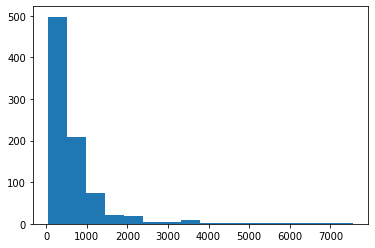

In [26]:
plt.hist(df_text[TEXT].str.split().str.len(), bins=16)
plt.show()

In [27]:
# df_text.loc[df_text[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT, TEXT].str.split().str.len()

In [28]:
def clean_text(text):
    """
    @text: a string
    Returns a cleaned version of the provided string
    """
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replaces REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # deletes symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # deletes stopwords from text
    return text

def lemmatize_text(text):
    """
    @text: a string
    Returns a lemmatized version of the provided string
    """
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

In [29]:
# print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")

# df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
# print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

# df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
# print(f"Amount of words after cleaning text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

# 1. BoW approach

## Preprocessing

In [30]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

X_train, X_test, y_train, y_test = split_data(df_text, LEMMATIZED, test_size=0.2, random_state=0)

X_train_tr, X_test_tr = vectorize_data(LEMMATIZED, X_train, X_test, ngram_range=(1, 1))

## Modeling

In [31]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')
    ), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)
    ), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)
    ),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')
    ),
    ('MultinomialNB', MultinomialNB()
    ),
    ]

In [32]:
print_stratified_kfold(clfs, X_train_tr, y_train)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [121 122 125]
	Mean y: TRAIN: 2.394,	VALIDATION: 2.372
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [255 258 260]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [364 370 371]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [481 498 512]
	Mean y: TRAIN: 2.392,	VALIDATION: 2.380
Cross validation scores: mean: 0.780, all: [0.723, 0.788, 0.818, 0.73, 0.839]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index 

Logistic Regression is the model with the best results on the validation set, so it will be the chosen model.

We will calculate results on the test set on all models just to compare, without changing the decision, hence without causing data leakage:

In [33]:
clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.790698
RandomForest        0.750000
KNN 5               0.668605
SVM C1              0.761628
MultinomialNB       0.616279
Best classifier: LogisticRegression, test accuracy: 0.791


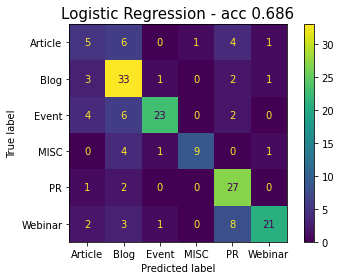


              precision    recall  f1-score   support

     Article       0.33      0.29      0.31        17
        Blog       0.61      0.82      0.70        40
       Event       0.88      0.66      0.75        35
        MISC       0.90      0.60      0.72        15
          PR       0.63      0.90      0.74        30
     Webinar       0.88      0.60      0.71        35

    accuracy                           0.69       172
   macro avg       0.71      0.65      0.66       172
weighted avg       0.72      0.69      0.68       172



In [34]:
# Just for comparison purposes

clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix('Logistic Regression', y_test, y_pred, with_report=True)

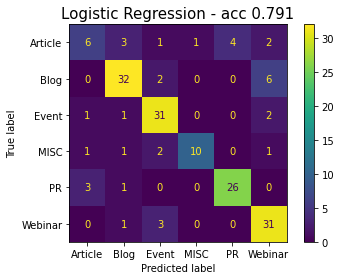


              precision    recall  f1-score   support

     Article       0.55      0.35      0.43        17
        Blog       0.82      0.80      0.81        40
       Event       0.79      0.89      0.84        35
        MISC       0.91      0.67      0.77        15
          PR       0.87      0.87      0.87        30
     Webinar       0.74      0.89      0.81        35

    accuracy                           0.79       172
   macro avg       0.78      0.74      0.75       172
weighted avg       0.79      0.79      0.78       172



In [52]:
# Chosen model

clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced',
                                   ), 
                X_train_tr, 
                y_train,
                )

y_pred = predict(clf, X_test_tr)
y_probs = clf.predict_proba(X_test_tr)

print_confusion_matrix('Logistic Regression', y_test, y_pred, with_report=True)

In [29]:
pickle.dump(clf, open('/content/drive/MyDrive/url_classification/Models/bow_lr_clf', 'wb'))

In [ ]:
# bow_lr_clf = pickle.load(open('/content/drive/MyDrive/url_classification/Models/bow_lr_clf', 'rb'))

In [36]:
df_mistakes = create_df_mistakes(df_text, LEMMATIZED, X_test, y_test, y_pred, y_probs)

In [45]:
save_variables({'df_mistakes_bow_lr_clf': df_mistakes})

In [37]:
df_mistakes.head()

,url,cleaned_lemmatized_text,y_true,conf_true,y_pred,conf_pred
932,http://www.zacks.com/stock/news/1348735/iqvia-...,IQVIA IQV buy remain Q2 Solutions Stake Ups EP...,PR,0.10,Article,0.23
821,http://www.threadresearch.com/blog/reduce-clin...,reduce Clinical Trial Costs use decentralize c...,Blog,0.19,Webinar,0.26
880,http://medrio.com/resource/the-power-of-patien...,Power Patient Centricity Rare Disease Studies ...,Blog,0.09,Webinar,0.29
958,http://www.outsourcing-pharma.com/Article/2021...,PPD Clinical Ink join lupus assessment endpoin...,Article,0.22,Webinar,0.28
904,http://www.calyx.ai/journal/a-medical-perspect...,introduce Medical Perspective Clinical Trial T...,Blog,0.09,Webinar,0.28


Confidence of incorrectly classified samples 	- Median: 0.2809, Mean: 0.3066.
Confidence of correctly classified samples 	- Median: 0.4467, Mean: 0.4813.



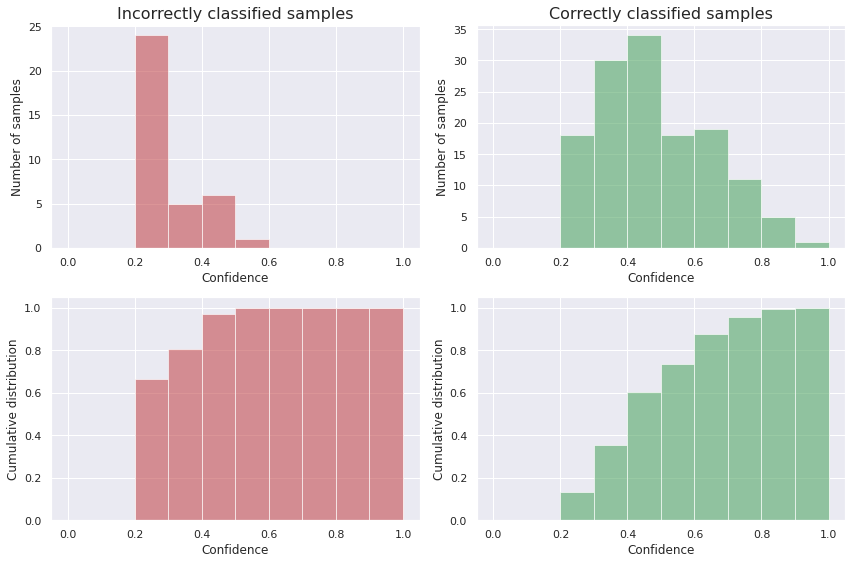

In [51]:
plot_distribution_of_confidences(y_test, y_pred, y_probs)

# 2. DistilBERT approach (Ashwin N)

### Preprocessing

In [101]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

### a) ML approach - extra preprocessing + modeling:

### Extra preprocessing

In [ ]:
X_train, X_test, y_train, y_test = split_data(df_text, column=TEXT, test_size=0.2, val_size=None, random_state=0)

dataset = create_dataset_dict(X_train, X_test, y_train, y_test)

dataset_encoded = dataset.map(
    tokenize, 
    batched=True, 
    batch_size=None,
    )

dataset_encoded.reset_format()

dataset_hidden = dataset_encoded.map(
    extract_hidden_states, 
    batched=True, 
    batch_size=16,
    )

X_train_hidden = np.array(dataset_hidden['train']['hidden_state'])
y_train_hidden = np.array(dataset_hidden['train'][TARGET])

X_test_hidden = np.array(dataset_hidden['test']['hidden_state'])
y_test_hidden = np.array(dataset_hidden['test'][TARGET])

In [ ]:
save_variables({'X_train_hidden': X_train_hidden,
                'X_test_hidden': X_test_hidden,
                'y_train_hidden': y_train_hidden,
                'y_test_hidden': y_test_hidden,
                })

### Modeling

In [40]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')
    ), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)
    ), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)
    ),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')
    ),
    ]

In [41]:
print_stratified_kfold(clfs, X_train_hidden, y_train)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [121 122 125]
	Mean y: TRAIN: 2.394,	VALIDATION: 2.372
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [255 258 260]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [364 370 371]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [481 498 512]
	Mean y: TRAIN: 2.392,	VALIDATION: 2.380
Cross validation scores: mean: 0.794, all: [0.788, 0.788, 0.839, 0.73, 0.825]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index 

Again Logistic Regression is the model with the best score when doing cross validation, so that's the chosen model.

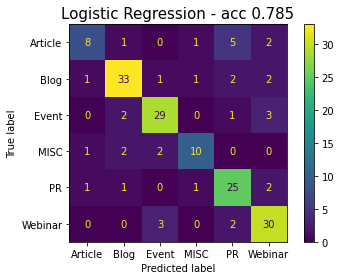


              precision    recall  f1-score   support

     Article       0.73      0.47      0.57        17
        Blog       0.85      0.82      0.84        40
       Event       0.83      0.83      0.83        35
        MISC       0.77      0.67      0.71        15
          PR       0.71      0.83      0.77        30
     Webinar       0.77      0.86      0.81        35

    accuracy                           0.78       172
   macro avg       0.78      0.75      0.75       172
weighted avg       0.79      0.78      0.78       172



In [53]:
# Just for comparison

lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                      class_weight='balanced',
                                      solver='liblinear', # default: 'lbfgs' 
                                      penalty='l1', # default: 'l2'
                                      ), 
                   X_train_hidden, 
                   y_train_hidden,
                   )

y_pred = predict(lr_clf, X_test_hidden)
y_probs = lr_clf.predict_proba(X_test_hidden)

print_confusion_matrix('Logistic Regression', y_test_hidden, y_pred, with_report=True)

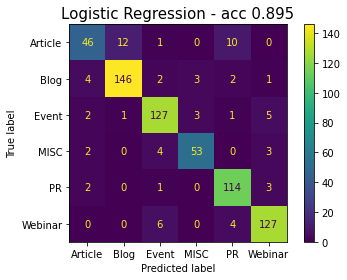


              precision    recall  f1-score   support

     Article       0.82      0.67      0.74        69
        Blog       0.92      0.92      0.92       158
       Event       0.90      0.91      0.91       139
        MISC       0.90      0.85      0.88        62
          PR       0.87      0.95      0.91       120
     Webinar       0.91      0.93      0.92       137

    accuracy                           0.89       685
   macro avg       0.89      0.87      0.88       685
weighted avg       0.89      0.89      0.89       685



In [54]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_hidden)
print_confusion_matrix('Logistic Regression', y_train_hidden, y_pred_train, with_report=True)

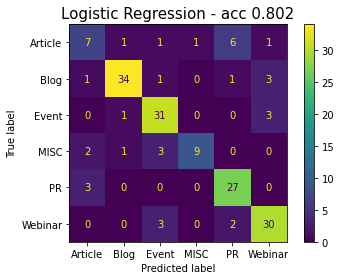


              precision    recall  f1-score   support

     Article       0.54      0.41      0.47        17
        Blog       0.92      0.85      0.88        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.75      0.90      0.82        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.75      0.76       172
weighted avg       0.80      0.80      0.80       172



In [55]:
# Just for comparison

lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_hidden, 
                y_train_hidden)

y_pred = predict(lr_clf, X_test_hidden)
y_probs = lr_clf.predict_proba(X_test_hidden)

print_confusion_matrix('Logistic Regression', y_test_hidden, y_pred, with_report=True)

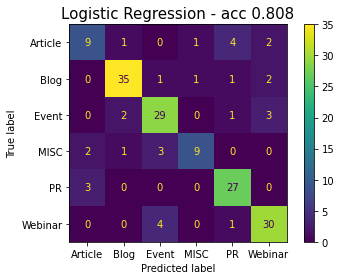


              precision    recall  f1-score   support

     Article       0.64      0.53      0.58        17
        Blog       0.90      0.88      0.89        40
       Event       0.78      0.83      0.81        35
        MISC       0.82      0.60      0.69        15
          PR       0.79      0.90      0.84        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.81       172
   macro avg       0.79      0.77      0.77       172
weighted avg       0.81      0.81      0.80       172



In [56]:
# Just for comparison

lr_clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='saga', # default: 'lbfgs' 
    penalty='elasticnet', # default: 'l2',
    l1_ratio=0.5, # only relevant when penalty='elasticnet'
    ), 
                X_train_hidden, 
                y_train_hidden)

y_pred = predict(lr_clf, X_test_hidden)
y_probs = lr_clf.predict_proba(X_test_hidden)

print_confusion_matrix('Logistic Regression', y_test_hidden, y_pred, with_report=True)

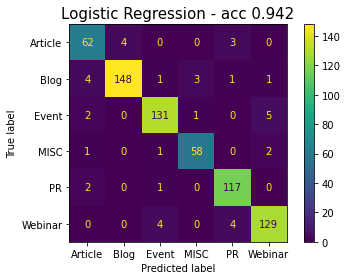


              precision    recall  f1-score   support

     Article       0.87      0.90      0.89        69
        Blog       0.97      0.94      0.95       158
       Event       0.95      0.94      0.95       139
        MISC       0.94      0.94      0.94        62
          PR       0.94      0.97      0.96       120
     Webinar       0.94      0.94      0.94       137

    accuracy                           0.94       685
   macro avg       0.93      0.94      0.94       685
weighted avg       0.94      0.94      0.94       685



In [57]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_hidden)
print_confusion_matrix('Logistic Regression', y_train_hidden, y_pred_train, with_report=True)

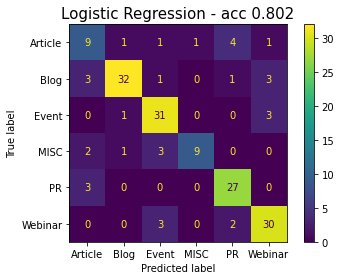


              precision    recall  f1-score   support

     Article       0.53      0.53      0.53        17
        Blog       0.91      0.80      0.85        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.79      0.90      0.84        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.76      0.77       172
weighted avg       0.81      0.80      0.80       172



In [58]:
# Chosen model

lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_hidden, 
                y_train_hidden)

y_pred = predict(lr_clf, X_test_hidden)
y_probs = lr_clf.predict_proba(X_test_hidden)

print_confusion_matrix('Logistic Regression', y_test_hidden, y_pred, with_report=True)

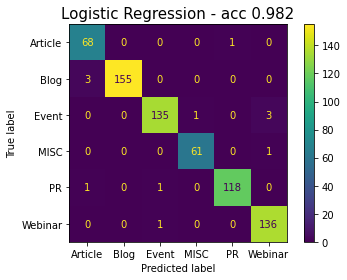


              precision    recall  f1-score   support

     Article       0.94      0.99      0.96        69
        Blog       1.00      0.98      0.99       158
       Event       0.99      0.97      0.98       139
        MISC       0.98      0.98      0.98        62
          PR       0.99      0.98      0.99       120
     Webinar       0.97      0.99      0.98       137

    accuracy                           0.98       685
   macro avg       0.98      0.98      0.98       685
weighted avg       0.98      0.98      0.98       685



In [59]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_hidden)
print_confusion_matrix('Logistic Regression', y_train_hidden, y_pred_train, with_report=True)

In [46]:
pickle.dump(lr_clf, open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'wb'))

In [ ]:
# lr_clf = pickle.load(open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'rb'))

In [60]:
df_mistakes = create_df_mistakes(df_text, TEXT, X_test, y_test, y_pred, y_probs)

In [49]:
save_variables({'df_mistakes_distilbert_lr_clf': df_mistakes})

In [61]:
df_mistakes.head()

,url,text,y_true,conf_true,y_pred,conf_pred
932,http://www.zacks.com/stock/news/1348735/iqvia-...,"IQVIA (IQV) Buys Remaining Q2 Solutions Stake,...",PR,0.01,Article,0.48
713,http://www.statnews.com/2022/02/08/cvs-medable...,CVS inks a deal with Medable to enroll more pa...,Article,0.00,Webinar,0.66
680,http://www.beckershospitalreview.com/healthcar...,California ends Verily COVID-19 testing partne...,Article,0.22,PR,0.76
84,NaN,"How to Use Hashtags: How Many, Best Ones, and ...",Blog,0.21,Article,0.52
791,http://www.calyx.ai/journal/overview-ema-lates...,Overview of EMA's latest IDMP Updates in 2022....,Blog,0.04,Webinar,0.58


In [62]:
misclassified = df_mistakes.shape[0]
misclassified_truncated = (df_mistakes[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT).sum()
print(f'Out of the {misclassified} misclassified samples, {misclassified_truncated}'
      f' ({misclassified_truncated / misclassified:.0%} of the total) were truncated.')

Out of the 34 misclassified samples, 11 (32% of the total) were truncated.


Confidence of incorrectly classified samples 	- Median: 0.5863, Mean: 0.6127.
Confidence of correctly classified samples 	- Median: 0.8798, Mean: 0.8284.



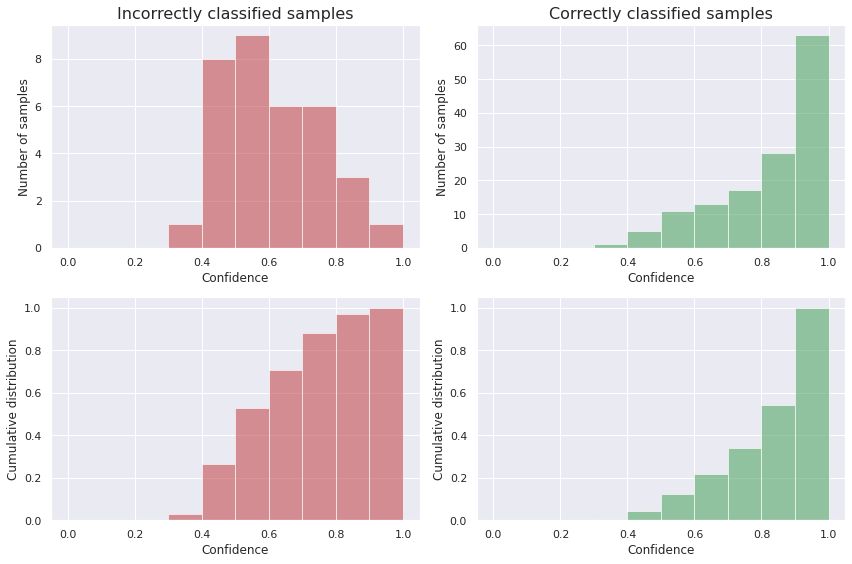

In [63]:
plot_distribution_of_confidences(y_test, y_pred, y_probs)

We can see that the model is a lot more confident in the correctly classified samples than what it was with the BoW approach, where a lot of times it was very confused even though it was right in its prediction.

### b) DL approach - extra preprocessing + modeling:

### Extra preprocessing

In [102]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_text, column=TEXT, test_size=0.2, val_size=0.1, random_state=0)

dataset = create_dataset_dict(X_train, X_test, y_train, y_test, X_val, y_val)

dataset_encoded = dataset.map(
    tokenize, 
    batched=True, 
    batch_size=None,
    )

tf_model = TFAutoModel.from_pretrained(model_ckpt)

tf_train_dataset, tf_val_dataset, tf_test_dataset = create_tf_dataset(dataset_encoded, tokenizer)

config = create_distilbert_config(dropout=0.1, attention_dropout=0.1)

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    config=config, 
    )
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
You're using a DistilBertTokenizerFast tokenizer. Please note that with 

### Modeling

In [74]:
tf_model = compile_model(tf_model, learning_rate=5e-6)

In [76]:
tf_model = train_model(tf_model, tf_train_dataset, tf_val_dataset, epochs=1000, patience=5)

Epoch 1/1000
38/38 [==============================] - 39s 1s/step - loss: 1.7366 - sparse_categorical_accuracy: 0.3773 - val_loss: 1.6817 - val_sparse_categorical_accuracy: 0.5581
Epoch 2/1000
38/38 [==============================] - 37s 968ms/step - loss: 1.5819 - sparse_categorical_accuracy: 0.5192 - val_loss: 1.4792 - val_sparse_categorical_accuracy: 0.6395
Epoch 3/1000
38/38 [==============================] - 37s 980ms/step - loss: 1.3402 - sparse_categorical_accuracy: 0.6912 - val_loss: 1.2807 - val_sparse_categorical_accuracy: 0.6395
Epoch 4/1000
38/38 [==============================] - 37s 969ms/step - loss: 1.1370 - sparse_categorical_accuracy: 0.7129 - val_loss: 1.0966 - val_sparse_categorical_accuracy: 0.6977
Epoch 5/1000
38/38 [==============================] - 37s 968ms/step - loss: 0.9675 - sparse_categorical_accuracy: 0.7663 - val_loss: 0.9856 - val_sparse_categorical_accuracy: 0.7093
Epoch 6/1000
38/38 [==============================] - 37s 964ms/step - loss: 0.8334 - sp

KeyboardInterrupt: ignored

In [ ]:
# epochs = 1000
# patience = 5

# tf_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=tf.metrics.SparseCategoricalAccuracy()
#     )

# callback = EarlyStopping(
#     monitor='val_loss',
#     patience=patience,
#     restore_best_weights=True
#     )

# history = tf_model.fit(
#     tf_train_dataset,
#     validation_data=tf_val_dataset, 
#     epochs=epochs,
#     callbacks=[callback]
#     )

Epoch 1/1000
38/38 [==============================] - 48s 1s/step - loss: 1.7609 - sparse_categorical_accuracy: 0.2521 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.4767
Epoch 2/1000
38/38 [==============================] - 37s 979ms/step - loss: 1.6179 - sparse_categorical_accuracy: 0.5893 - val_loss: 1.5302 - val_sparse_categorical_accuracy: 0.7093
Epoch 3/1000
38/38 [==============================] - 37s 980ms/step - loss: 1.4147 - sparse_categorical_accuracy: 0.6878 - val_loss: 1.3233 - val_sparse_categorical_accuracy: 0.6977
Epoch 4/1000
38/38 [==============================] - 37s 987ms/step - loss: 1.2047 - sparse_categorical_accuracy: 0.7078 - val_loss: 1.1303 - val_sparse_categorical_accuracy: 0.7093
Epoch 5/1000
38/38 [==============================] - 37s 982ms/step - loss: 1.0323 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.7209
Epoch 6/1000
38/38 [==============================] - 38s 988ms/step - loss: 0.8964 - sp

In [ ]:
# tf.keras.models.save_model(
#     tf_model, 
#     filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89', 
#     overwrite=True, 
#     save_format='tf'
#     )

In [ ]:
tf_model.save('/content/drive/MyDrive/Brew/my_model_val0.87_test0.8')

In [ ]:
# ! pwd

/content/drive/.shortcut-targets-by-id/1vLy-uUgLo6ivB3DawGntodciS6HG1L58/url_classification


In [ ]:
# tf.saved_model.save(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
tf_model2 = load_model(filepath='/content/drive/MyDrive/Brew/my_model_delete') 

In [ ]:
tf_model2 = tf.saved_model.load('/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
tf.keras.models.save_model(tf_model, '/content/drive/MyDrive/url_classification/my_model_val0.81_test0.85')

In [ ]:
tf_model2 = tf.keras.models.load_model(filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89') 
# # why doesn't it work when running the next cell with the loaded model?

OSError: ignored

In [ ]:
custom_objects = {"TFAutoModelForSequenceClassification": TFAutoModelForSequenceClassification}

tf_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Brew/my_model_delete', custom_objects=custom_objects)

In [ ]:
# loss, train_accuracy = tf_model2.evaluate(tf_train_dataset)
# print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

In [77]:
loss, train_accuracy = tf_model.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

38/38 [==============================] - 12s 303ms/step - loss: 0.7129 - sparse_categorical_accuracy: 0.8347
Loss: 0.7129414677619934	 Train Accuracy: 0.8347245454788208


In [78]:
loss, eval_accuracy = tf_model.evaluate(tf_val_dataset)
print("Loss: {}\t Eval Accuracy: {}".format(loss, eval_accuracy))

6/6 [==============================] - 2s 275ms/step - loss: 0.8639 - sparse_categorical_accuracy: 0.7326
Loss: 0.8638859987258911	 Eval Accuracy: 0.7325581312179565


In [79]:
loss, test_accuracy = tf_model.evaluate(tf_test_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, test_accuracy))

11/11 [==============================] - 3s 306ms/step - loss: 0.8307 - sparse_categorical_accuracy: 0.7791
Loss: 0.830740749835968	 Test Accuracy: 0.7790697813034058


In [80]:
output_logits = tf_model.predict(tf_test_dataset).logits
y_pred = np.argmax(output_logits, axis=-1)

11/11 [==============================] - 5s 308ms/step


In [93]:
y_probs = tf.nn.softmax(output_logits).numpy()
y_probs[:3]

array([[0.10250348, 0.70475256, 0.02832884, 0.0459688 , 0.04692442,
        0.07152189],
       [0.17751543, 0.35870397, 0.059831  , 0.06598082, 0.16091269,
        0.17705615],
       [0.12317823, 0.6029603 , 0.03500713, 0.09156387, 0.07884642,
        0.06844407]], dtype=float32)

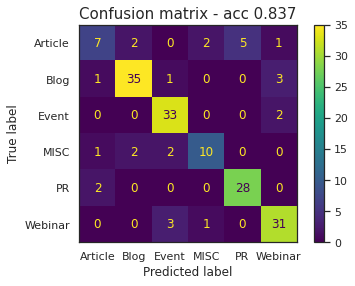


              precision    recall  f1-score   support

     Article       0.64      0.41      0.50        17
        Blog       0.90      0.88      0.89        40
       Event       0.85      0.94      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.85      0.93      0.89        30
     Webinar       0.84      0.89      0.86        35

    accuracy                           0.84       172
   macro avg       0.81      0.79      0.79       172
weighted avg       0.83      0.84      0.83       172



In [ ]:
print_confusion_matrix('Deep Learning', y_test, y_pred, with_report=True)

In [95]:
df_mistakes = create_df_mistakes(df_text, TEXT, X_test, y_test, y_pred, y_probs)

In [99]:
df_mistakes.head()

,url,text,y_true,conf_true,y_pred,conf_pred
932,http://www.zacks.com/stock/news/1348735/iqvia-...,"IQVIA (IQV) Buys Remaining Q2 Solutions Stake,...",PR,0.16,Blog,0.36
713,http://www.statnews.com/2022/02/08/cvs-medable...,CVS inks a deal with Medable to enroll more pa...,Article,0.06,Webinar,0.37
680,http://www.beckershospitalreview.com/healthcar...,California ends Verily COVID-19 testing partne...,Article,0.22,PR,0.44
791,http://www.calyx.ai/journal/overview-ema-lates...,Overview of EMA's latest IDMP Updates in 2022....,Blog,0.06,Webinar,0.55
958,http://www.outsourcing-pharma.com/Article/2021...,"PPD, Clinical Ink join on lupus assessment and...",Article,0.20,PR,0.46


Confidence of incorrectly classified samples 	- Median: 0.4870, Mean: 0.4846.
Confidence of correctly classified samples 	- Median: 0.6349, Mean: 0.6061.



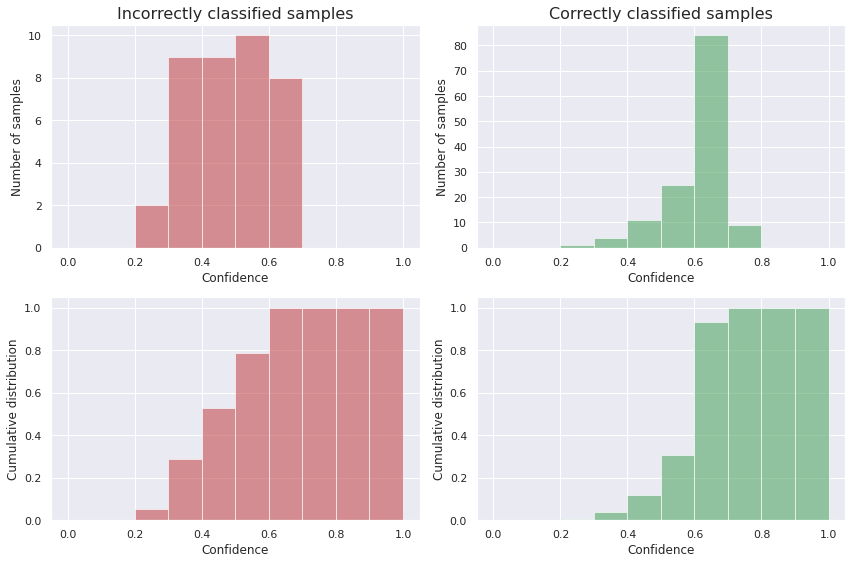

In [97]:
plot_distribution_of_confidences(y_test, y_pred, y_probs)

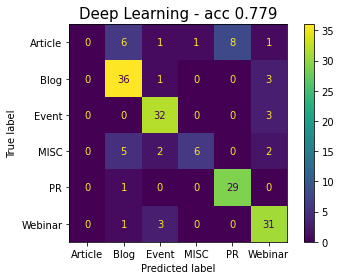


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.73      0.90      0.81        40
       Event       0.82      0.91      0.86        35
        MISC       0.86      0.40      0.55        15
          PR       0.78      0.97      0.87        30
     Webinar       0.78      0.89      0.83        35

    accuracy                           0.78       172
   macro avg       0.66      0.68      0.65       172
weighted avg       0.71      0.78      0.73       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
print_confusion_matrix('Deep Learning', y_test, y_pred, with_report=True)

In [100]:
save_variables({'df_mistakes_distilbert_nn': df_mistakes})